In [45]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt


def generate_reservoir(n_inputs, n_reservoir, spectral_radius, input_scaling=1.0, leaking_rate=1.0, seed=None):
    if seed is not None:
        np.random.seed(seed)

    Win = (np.random.rand(n_reservoir, 1 + n_inputs) - 0.5) * 2 * input_scaling
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5

    rhoW = np.max(np.abs(linalg.eigvals(W)))
    W *= spectral_radius / rhoW

    return Win, W


def train_esn(u_train, y_train, Win, W, leaking_rate=1.0, washout=100, ridge=1e-8):
    T = len(u_train)
    n_res = W.shape[0]
    n_in = u_train.shape[1]

    X = np.zeros((1 + n_in + n_res, T - washout))
    Yt = y_train[washout:].T

    x = np.zeros((n_res, 1))

    for t in range(T):
        u = u_train[t].reshape(-1, 1)
        x = (1 - leaking_rate) * x + leaking_rate * np.tanh(Win @ np.vstack((1, u)) + W @ x)

        if t >= washout:
            X[:, t - washout] = np.vstack((1, u, x))[:, 0]

    XX = X @ X.T
    Wout = (Yt @ X.T) @ linalg.inv(XX + ridge * np.eye(XX.shape[0]))

    return Wout, x


def predict_autonomous(initial_input, Win, W, Wout, steps, leaking_rate=1.0, x0=None):
    n_res = W.shape[0]
    n_in = initial_input.shape[0]

    x = np.zeros((n_res, 1)) if x0 is None else x0.copy()
    u = initial_input.reshape(-1, 1)

    Y = np.zeros((steps, Wout.shape[0]))

    for t in range(steps):
        x = (1 - leaking_rate) * x + leaking_rate * np.tanh(Win @ np.vstack((1, u)) + W @ x)
        y = Wout @ np.vstack((1, u, x))
        Y[t] = y[:, 0]
        u = y

    return Y

def nrmse(true, pred):
    return np.sqrt(np.mean((true - pred)**2)) / np.std(true)


def grid_search_esn(
    u_train, y_train,
    u_val, y_val,
    resSize=300,
    washout=100,
    autonomous_steps=500,
    ridge=1e-8,
    seed=999
):

    # ================================
    # 1. COARSE GRID
    # ================================
    coarse_grid = {
        "spectral_radius": [0.6, 0.9, 1.2, 1.5],
        "input_scaling":   [0.1, 0.5, 1.0],
        "leaking_rate":    [0.1, 0.3, 0.6, 1.0]
    }

    best_score = np.inf
    best_params = None

    for sr in coarse_grid["spectral_radius"]:
        for ins in coarse_grid["input_scaling"]:
            for leak in coarse_grid["leaking_rate"]:

                Win, W = generate_reservoir(
                    n_inputs=u_train.shape[1],
                    n_reservoir=resSize,
                    spectral_radius=sr,
                    input_scaling=ins,
                    leaking_rate=leak,
                    seed=seed
                )

                Wout, last_x = train_esn(
                    u_train, y_train,
                    Win, W,
                    leaking_rate=leak,
                    washout=washout,
                    ridge=ridge
                )

                # autonomous validation
                initial_input = u_val[0]
                pred = predict_autonomous(
                    initial_input, Win, W, Wout,
                    steps=autonomous_steps,
                    leaking_rate=leak,
                    x0=last_x
                ).flatten()

                true = y_val[:autonomous_steps].flatten()
                score = nrmse(true, pred)

                print(f"[COARSE] SR={sr:.3f}, IN={ins:.3f}, LEAK={leak:.3f} → NRMSE={score:.4f}")

                if score < best_score:
                    best_score = score
                    best_params = {"spectral_radius": sr, "input_scaling": ins, "leaking_rate": leak}

    print("\n=== BEST COARSE PARAMS:", best_params, "NRMSE=", best_score, "===")

    # ================================
    # 2. FINE GRID (local refinement)
    # ================================
    fine_grid = {
        "spectral_radius": [best_params["spectral_radius"] * v for v in [0.8, 1.0, 1.2]],
        "input_scaling":   [best_params["input_scaling"] * v for v in [0.8, 1.0, 1.2]],
        "leaking_rate":    [best_params["leaking_rate"] * v for v in [0.8, 1.0, 1.2]]
    }

    best_score_fine = np.inf
    best_params_fine = None

    for sr in fine_grid["spectral_radius"]:
        for ins in fine_grid["input_scaling"]:
            for leak in fine_grid["leaking_rate"]:

                Win, W = generate_reservoir(
                    n_inputs=u_train.shape[1],
                    n_reservoir=resSize,
                    spectral_radius=sr,
                    input_scaling=ins,
                    leaking_rate=leak,
                    seed=seed
                )

                Wout, last_x = train_esn(
                    u_train, y_train,
                    Win, W,
                    leaking_rate=leak,
                    washout=washout,
                    ridge=ridge
                )

                pred = predict_autonomous(
                    u_val[0], Win, W, Wout,
                    steps=autonomous_steps,
                    leaking_rate=leak,
                    x0=last_x
                ).flatten()

                true = y_val[:autonomous_steps].flatten()
                score = nrmse(true, pred)

                print(f"[FINE] SR={sr:.3f}, IN={ins:.3f}, LEAK={leak:.3f} → NRMSE={score:.4f}")

                if score < best_score_fine:
                    best_score_fine = score
                    best_params_fine = {"spectral_radius": sr, "input_scaling": ins, "leaking_rate": leak}

    print("\n=== BEST FINE PARAMS:", best_params_fine, "NRMSE=", best_score_fine, "===")

    return best_params_fine


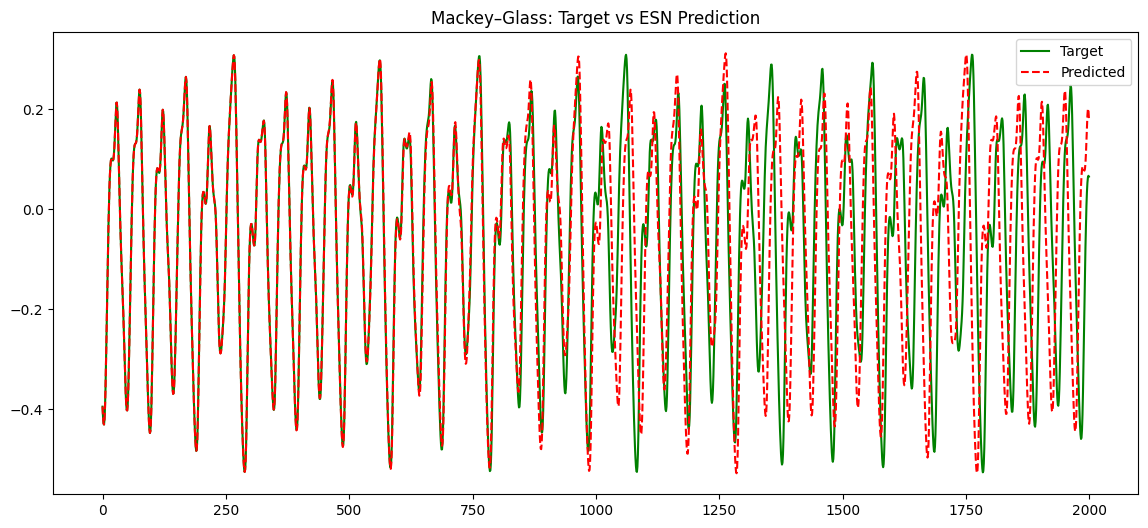

In [48]:
# Load data
data = np.loadtxt('../data/MackeyGlass_t17.txt')

trainLen = 2000
testLen  = 2000
initLen  = 100

u_train = data[:trainLen].reshape(-1, 1)
y_train = data[1:trainLen+1].reshape(-1, 1)

# Generate reservoir
Win, W = generate_reservoir(
    n_inputs=1,
    n_reservoir=5000,
    spectral_radius=1.3,
    input_scaling=1.0,
    leaking_rate=0.3,
    seed=42
)

# Train
Wout, last_state = train_esn(
    u_train, y_train,
    Win, W,
    leaking_rate=0.3,
    washout=initLen,
    ridge=1e-8
)

# Predict generatively
initial = data[trainLen].reshape(1)
Y = predict_autonomous(
    initial_input=initial,
    Win=Win, W=W, Wout=Wout,
    steps=testLen,
    leaking_rate=0.3,
    x0=last_state
)

# Plot
plt.figure(figsize=(14,6))
plt.plot(data[trainLen+1:trainLen+testLen+1], 'g', label="Target")
plt.plot(Y, 'r--', label="Predicted")
plt.legend()
plt.title("Mackey–Glass: Target vs ESN Prediction")
plt.show()


In [ ]:
data = np.loadtxt('../data/MackeyGlass_t17.txt')

trainLen = 3000
valLen = 2000
initLen = 100

u_train = data[:trainLen].reshape(-1,1)
y_train = data[1:trainLen+1].reshape(-1,1)

u_val = data[trainLen:trainLen+valLen].reshape(-1,1)
y_val = data[trainLen+1:trainLen+valLen+1].reshape(-1,1)


best_params = grid_search_esn(
    u_train, y_train,
    u_val, y_val,
    resSize=300,
    washout=initLen,
    autonomous_steps=800,
    ridge=1e-8,
    seed=42
)

print("BEST PARAMETERS FOUND:", best_params)
